In [2]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

In [3]:
df = pd.read_json('matches.jsonl', lines=True)

df

,match_id,summoner_id,team_key,position,game_length_second,summoner_level,champion_id,trinket_item,item_0,item_1,...,death,assist,neutral_minion_kill,gold_earned,total_heal,result,role,lane,individual_position,team_position
0,KR_6988447866,Hf53SP7jqpACVSR5pVHYCnJNgaO00xmv7yHEF0UhAYKpvvE,100,MIDDLE,1986,210,17,3363,3135,6653,...,6,10,8,13826,4624,0,DUO,MIDDLE,TOP,TOP
1,KR_6988447866,hJwiBotmkw1satykCtXAXzlHQE_wZxy3uU4DZ7wYqC5A6A,100,JUNGLE,1986,639,64,3340,3071,6610,...,4,8,215,14601,26467,0,NONE,JUNGLE,JUNGLE,JUNGLE
2,KR_6988447866,UjHUSaaiEVgZrvC3zeBCLmv_K8m0R87MSicrbkHiQQqKO3E,100,MIDDLE,1986,407,43,3340,3158,4629,...,4,10,6,12428,2574,0,DUO,MIDDLE,MIDDLE,MIDDLE
3,KR_6988447866,NbANlXEPqOOiCIz28URsaP3SsZ4aXZOM8Tbwu2uGPKoFbM...,100,BOTTOM,1986,126,110,3363,3091,3087,...,5,3,12,13612,5394,0,CARRY,BOTTOM,BOTTOM,BOTTOM
4,KR_6988447866,S3gB7SbBOsjIKzjd2VLEKOjGkEqdAhdNhO64tE-jiferf9Q,100,BOTTOM,1986,306,111,3364,3050,3876,...,8,9,0,8203,1,0,SUPPORT,BOTTOM,UTILITY,UTILITY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111705,KR_6982913850,tkxAMy6VVTwvOLVijcGH1p8PnpRO35IVhx2FbdBeTIF0t8g,200,NONE,1110,242,121,3364,1102,3142,...,3,2,90,7333,9323,0,SUPPORT,NONE,JUNGLE,JUNGLE
111706,KR_6982913850,5m7MJ3ADFnDUGBlrXGMsJjIS5quyjdsrtlO98bC_UROqiBE,200,NONE,1110,224,516,3340,2031,6664,...,3,4,0,5879,234,0,SUPPORT,NONE,TOP,TOP
111707,KR_6982913850,t0vCMmzuRRUsxwIB3j6Gt-5m73Exf2GFr9I6IAdapmDEiP0,200,NONE,1110,431,103,3340,3020,2055,...,4,0,0,7268,2013,0,SUPPORT,NONE,MIDDLE,MIDDLE
111708,KR_6982913850,8FZb64fNWnULPhXbivrkS_ytylESTJ01EtiS4gjq7vjFC4...,200,NONE,1110,67,236,3340,1055,3006,...,6,0,0,6668,1746,0,SUPPORT,NONE,BOTTOM,BOTTOM


In [4]:
new_data = []

# 각 팀별로 데이터를 수집합니다.
for i in range(0, len(df), 5):  # 여기서는 예시 데이터가 2개밖에 없으므로, 실제 데이터에 맞게 조정해야 합니다.
    team_data = df.iloc[i:i+5]  # 5개의 row를 선택 (실제 데이터가 5개 이상일 때 유효)
    if not team_data.empty:
        champion_ids = team_data['champion_id'].tolist()
        result = team_data['result'].iloc[0]  # 가정: 한 팀 내 모든 row의 승리 여부가 동일합니다.
        new_data.append(champion_ids + [result])

# 새로운 DataFrame 생성
columns = [f'user{i+1}' for i in range(5)] + ['win']
new_df = pd.DataFrame(new_data, columns=columns)

print(new_df)

       user1  user2  user3  user4  user5  win
0         17     64     43    110    111    0
1        516    141    136    222     48    1
2        126    163    950    221    555    1
3         68    234    777     81    412    0
4         75     64     91    145    268    0
...      ...    ...    ...    ...    ...  ...
22337    221    350     32    103     98    0
22338     76    266    111    523    777    0
22339    517     57     21     58     91    1
22340     82     76    238     29     89    1
22341    121    516    103    236     22    0

[22342 rows x 6 columns]


In [5]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def calculate_score(comb_winrate, self_winrate, play_count, mu_play_matrix, sigma_play_matrix ,alpha=1):
    x = alpha * ((play_count - mu_play_matrix) / sigma_play_matrix)

    weight = sigmoid(x)

    score = comb_winrate * weight + self_winrate * (1 - weight)

    return score

# synergy_set with score
def get_synergy_set(most3_champions, n_champion, win_rate, self_winrate, play_matrix):
    mu_play_matrix = np.mean(play_matrix)
    sigma_play_matrix = np.std(play_matrix)

    synergy_set = dict()
    for i in most3_champions:
        for j in range(n_champion):
            if i != j:
                score = calculate_score(win_rate[i, j], self_winrate[i], play_matrix[i, j], mu_play_matrix, sigma_play_matrix)
                if synergy_set.get(j) is None:
                    synergy_set[j] = score
                else:
                    synergy_set[j] += score

    print(synergy_set)

    synergy_set = sorted(synergy_set.items(), key=lambda x: x[1], reverse=True)[:10]

    return synergy_set

In [6]:
import json

with open('champion_name_key.json', 'r') as f:
    champion_name_key = json.load(f)

champion_name_key

{'266': 'Aatrox',
 '103': 'Ahri',
 '84': 'Akali',
 '166': 'Akshan',
 '12': 'Alistar',
 '32': 'Amumu',
 '34': 'Anivia',
 '1': 'Annie',
 '523': 'Aphelios',
 '22': 'Ashe',
 '136': 'AurelionSol',
 '268': 'Azir',
 '432': 'Bard',
 '200': 'Belveth',
 '53': 'Blitzcrank',
 '63': 'Brand',
 '201': 'Braum',
 '233': 'Briar',
 '51': 'Caitlyn',
 '164': 'Camille',
 '69': 'Cassiopeia',
 '31': 'Chogath',
 '42': 'Corki',
 '122': 'Darius',
 '131': 'Diana',
 '119': 'Draven',
 '36': 'DrMundo',
 '245': 'Ekko',
 '60': 'Elise',
 '28': 'Evelynn',
 '81': 'Ezreal',
 '9': 'Fiddlesticks',
 '114': 'Fiora',
 '105': 'Fizz',
 '3': 'Galio',
 '41': 'Gangplank',
 '86': 'Garen',
 '150': 'Gnar',
 '79': 'Gragas',
 '104': 'Graves',
 '887': 'Gwen',
 '120': 'Hecarim',
 '74': 'Heimerdinger',
 '910': 'Hwei',
 '420': 'Illaoi',
 '39': 'Irelia',
 '427': 'Ivern',
 '40': 'Janna',
 '59': 'JarvanIV',
 '24': 'Jax',
 '126': 'Jayce',
 '202': 'Jhin',
 '222': 'Jinx',
 '145': 'Kaisa',
 '429': 'Kalista',
 '43': 'Karma',
 '30': 'Karthus',
 '38'

In [7]:
index2name = {v: k for k, v in enumerate(champion_name_key.keys())}
name2idx = {k: v for k, v in enumerate(champion_name_key.keys())}

In [ ]:
fake_player_most = [81, 222, 202]
fake_player_most_idx = [index2name[str(i)] for i in fake_player_most]

In [ ]:
fake_player_most_idx

[30, 52, 51]

In [8]:
# champion 개별 승률
user_cross1 = pd.crosstab(new_df['user1'], new_df['win'])
user_cross1['win_rate'] = user_cross1[1] / (user_cross1[0] + user_cross1[1])
user_cross1 = user_cross1.sort_values(by='win_rate', ascending=False)

user_cross2 = pd.crosstab(new_df['user2'], new_df['win'])
user_cross2['win_rate'] = user_cross2[1] / (user_cross2[0] + user_cross2[1])
user_cross2 = user_cross2.sort_values(by='win_rate', ascending=False)

user_cross3 = pd.crosstab(new_df['user3'], new_df['win'])
user_cross3['win_rate'] = user_cross3[1] / (user_cross3[0] + user_cross3[1])
user_cross3 = user_cross3.sort_values(by='win_rate', ascending=False)

user_cross4 = pd.crosstab(new_df['user4'], new_df['win'])
user_cross4['win_rate'] = user_cross4[1] / (user_cross4[0] + user_cross4[1])
user_cross4 = user_cross4.sort_values(by='win_rate', ascending=False)

user_cross5 = pd.crosstab(new_df['user5'], new_df['win'])
user_cross5['win_rate'] = user_cross5[1] / (user_cross5[0] + user_cross5[1])
user_cross5 = user_cross5.sort_values(by='win_rate', ascending=False)

# champion cross table 합하기
user_cross = user_cross1.add(user_cross2, fill_value=0).add(user_cross3, fill_value=0).add(user_cross4, fill_value=0).add(user_cross5, fill_value=0)
user_cross['win_rate'] = user_cross[1] / (user_cross[0] + user_cross[1])
user_cross = user_cross.sort_values(by='win_rate', ascending=False)

user_cross

win,0,1,win_rate
6,100,138,0.579832
37,37,51,0.579545
8,87,119,0.577670
133,74,97,0.567251
427,77,99,0.562500
...,...,...,...
85,145,110,0.431373
90,110,82,0.427083
42,136,98,0.418803
120,103,73,0.414773


In [9]:
N = 167

play_matrix = np.zeros((N, N), dtype=int)

print(new_df)
for d in new_df.values:
    for i in range(5):
        for j in range(i+1, 5):
            play_matrix[index2name[str(d[i])], index2name[str(d[j])]] += 1
            play_matrix[index2name[str(d[j])], index2name[str(d[i])]] += 1

play_matrix

       user1  user2  user3  user4  user5  win
0         17     64     43    110    111    0
1        516    141    136    222     48    1
2        126    163    950    221    555    1
3         68    234    777     81    412    0
4         75     64     91    145    268    0
...      ...    ...    ...    ...    ...  ...
22337    221    350     32    103     98    0
22338     76    266    111    523    777    0
22339    517     57     21     58     91    1
22340     82     76    238     29     89    1
22341    121    516    103    236     22    0

[22342 rows x 6 columns]


array([[  0, 155,  76, ...,  16,  18,  37],
       [155,   0,  27, ...,  20,   4,  34],
       [ 76,  27,   0, ...,  16,   1,  18],
       ...,
       [ 16,  20,  16, ...,   0,   2,   2],
       [ 18,   4,   1, ...,   2,   0,   5],
       [ 37,  34,  18, ...,   2,   5,   0]])

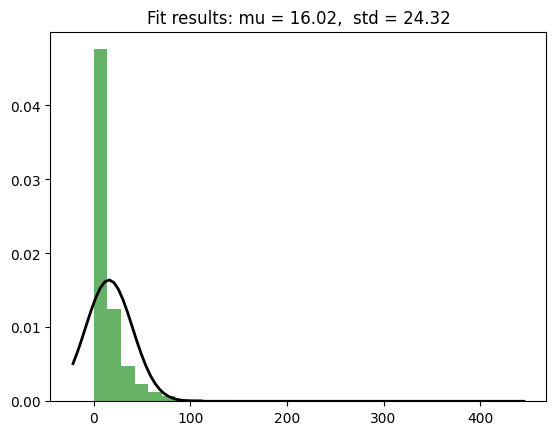

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# 행렬의 모든 값을 하나의 배열로 변환
values = play_matrix.flatten()

# 데이터의 히스토그램 그리기
plt.hist(values, bins=30, density=True, alpha=0.6, color='g')

# 데이터로부터 평균과 표준편차 계산
mu, std = norm.fit(values)

# 정규 분포 곡선 그리기
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

In [ ]:
win_count = np.zeros((N, N), dtype=int)

for d in new_df.values:
    if d[5] == 1:
        for i in range(5):
            for j in range(i+1, 5):
                win_count[index2name[str(d[i])], index2name[str(d[j])]] += 1
                win_count[index2name[str(d[j])], index2name[str(d[i])]] += 1


win_count

array([[ 0, 83, 34, ...,  8,  8, 13],
       [83,  0, 13, ...,  7,  2, 18],
       [34, 13,  0, ...,  8,  1,  9],
       ...,
       [ 8,  7,  8, ...,  0,  1,  0],
       [ 8,  2,  1, ...,  1,  0,  3],
       [13, 18,  9, ...,  0,  3,  0]])

In [ ]:
eps = 1e-10

win_rate = win_count / (play_matrix + eps)
win_rate[np.isnan(win_rate)] = 0
win_rate[np.isinf(win_rate)] = 0

for i in range(N):
    win_rate[i, i] = 0.5

win_rate

array([[0.5       , 0.53548387, 0.44736842, ..., 0.5       , 0.44444444,
        0.35135135],
       [0.53548387, 0.5       , 0.48148148, ..., 0.35      , 0.5       ,
        0.52941176],
       [0.44736842, 0.48148148, 0.5       , ..., 0.5       , 1.        ,
        0.5       ],
       ...,
       [0.5       , 0.35      , 0.5       , ..., 0.5       , 0.5       ,
        0.        ],
       [0.44444444, 0.5       , 1.        , ..., 0.5       , 0.5       ,
        0.6       ],
       [0.35135135, 0.52941176, 0.5       , ..., 0.        , 0.6       ,
        0.5       ]])

In [ ]:

self_win_rate = np.zeros(N, )

for i in range(N):
    self_win_rate[i] = user_cross.loc[int(name2idx[i]), 'win_rate']

self_win_rate

array([0.49490835, 0.52427714, 0.45717036, 0.52824859, 0.53198653,
       0.50931677, 0.55128205, 0.55813953, 0.45816187, 0.51594614,
       0.50401606, 0.51658768, 0.56012658, 0.5       , 0.50498849,
       0.52719033, 0.53443526, 0.48553055, 0.47177108, 0.52313883,
       0.48015873, 0.53378378, 0.41880342, 0.47457627, 0.45581395,
       0.48139535, 0.52400835, 0.50086957, 0.53353659, 0.50409836,
       0.46415373, 0.51438849, 0.51569507, 0.40865385, 0.53543307,
       0.52109181, 0.45814978, 0.48051948, 0.51236749, 0.50151362,
       0.50359712, 0.41477273, 0.51428571, 0.47438596, 0.49709302,
       0.48923679, 0.5625    , 0.51075269, 0.49462366, 0.54188211,
       0.5215655 , 0.48359073, 0.54533153, 0.49075975, 0.47818792,
       0.49766573, 0.55654762, 0.45816733, 0.4812362 , 0.51744186,
       0.48666667, 0.43137255, 0.50439367, 0.46389497, 0.55      ,
       0.52962963, 0.46902655, 0.47638327, 0.50177936, 0.5375    ,
       0.50724638, 0.48251748, 0.49940048, 0.50805687, 0.46660

In [ ]:
for i in range(N):
    win_rate[i, i] = self_win_rate[i]

win_rate

array([[0.49490835, 0.53548387, 0.44736842, ..., 0.5       , 0.44444444,
        0.35135135],
       [0.53548387, 0.52427714, 0.48148148, ..., 0.35      , 0.5       ,
        0.52941176],
       [0.44736842, 0.48148148, 0.45717036, ..., 0.5       , 1.        ,
        0.5       ],
       ...,
       [0.5       , 0.35      , 0.5       , ..., 0.5375    , 0.5       ,
        0.        ],
       [0.44444444, 0.5       , 1.        , ..., 0.5       , 0.53962264,
        0.6       ],
       [0.35135135, 0.52941176, 0.5       , ..., 0.        , 0.6       ,
        0.52446184]])

In [ ]:
ss = get_synergy_set(fake_player_most_idx, N, win_rate, self_win_rate, play_matrix)

{0: 1.5032546132441607, 1: 1.5806148513979152, 2: 1.4183111480647166, 3: 1.6569126897095945, 4: 1.491658857519695, 5: 1.4833156985397349, 6: 1.6547067217585345, 7: 1.6965053059013777, 8: 1.5747535948173688, 9: 1.2799780649214187, 10: 1.4698350181598514, 11: 1.5685428256773686, 12: 1.6899628846009653, 13: 1.59859603024845, 14: 1.4942854046118577, 15: 1.6175368402632808, 16: 1.552745705493153, 17: 1.5678050288349406, 18: 1.5006342397934165, 19: 1.616526346190257, 20: 1.5593694552064894, 21: 1.6642287071659572, 22: 1.3602958204975983, 23: 1.4587326475233042, 24: 1.4183214198708454, 25: 1.4453829955668775, 26: 1.6831256505526462, 27: 1.59518833132527, 28: 1.7612832297879275, 29: 1.4376333850464214, 31: 1.6258510403906812, 32: 1.5753831818543642, 33: 1.430948454966914, 34: 1.5462294635308536, 35: 1.514635734231766, 36: 1.4548890950790971, 37: 1.3761183154302046, 38: 1.4730668247845515, 39: 1.6118157757166212, 40: 1.4755150019040784, 41: 1.400502679354229, 42: 1.481450013216011, 43: 1.388195

In [ ]:
ss

[(124, 1.807944010921198),
 (28, 1.7612832297879275),
 (132, 1.7201064227503444),
 (129, 1.7124213765164202),
 (7, 1.6965053059013777),
 (12, 1.6899628846009653),
 (26, 1.6831256505526462),
 (84, 1.6645708693114423),
 (21, 1.6642287071659572),
 (121, 1.6618518279666137)]

In [ ]:
print([champion_name_key[name2idx[i]] for i, _ in ss])

['Sona', 'Elise', 'Taric', 'TahmKench', 'Annie', 'Bard', 'DrMundo', 'Naafiri', 'Chogath', 'Sivir']
